# Preparing the data and running NGC-6569 on scarlet

This notebook demonstrates how data must be formatted to execute scarlet to avoid some of the issues that Michael Johnson noticed will processing the NGC-6569 globular cluster images taken with the Dark Energy Camera (DECam) as part of the Rubin Observatory LSST-VTS Crowded Field working group.

In [1]:
# Import Packages and setup
import os
import pickle
from functools import partial

import numpy as np
from astropy.io import fits

import scarlet
from scarlet import display
import scarlet_extensions as se

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a good colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='Greys_r', interpolation='none', origin='lower')

# Load the data

In [2]:
# Import the cutouts that Michael selected for analysis
data_path = "/Users/fred/Downloads/scarlet_resources"
file_name = "NGC_6569_cutout_{}.fits"
filters = "ugriz"
images = [fits.open(os.path.join(data_path, file_name.format(f)))[0].data for f in filters]
images = np.asarray(images)
# Download the psf images
psf_path = "/Users/fred/Downloads/Michael"
psf_filename = "PSF_{}.fits"
_psfs = [fits.open(os.path.join(psf_path, psf_filename.format(f)))[0].data for f in filters]
_psfs = np.asarray(_psfs)

In [3]:
# Load the DECam "resampled" images from NOAO, along with the variance maps and data quality masks
decam_path = "/Users/fred/data"
filenames = [
    "c4d_130511_041112_op{}_u_v1.fits.fz",
    "c4d_130511_040903_op{}_g_v1.fits.fz",
    "c4d_130511_035740_op{}_r_v1.fits.fz",
    "c4d_130511_040445_op{}_i_v1.fits.fz",
    "c4d_130511_040655_op{}_z_v1.fits.fz",
]
hdulist = fits.open(os.path.join(decam_path, "c4d_130511_035740_opi_r_v1.fits.fz"))
img = hdulist[50]

# These are the slices required to properly select the same cutouts as Michaels images.
# I'm not sure why they aren't lined up, as these are supposed to be resampled onto the
# same pixel grid.
slices = [
    (slice(1100, 1300), slice(200, 400)), # u
    (slice(1088, 1288), slice(199, 399)), # g
    (slice(1095,1295), slice(228, 428)), # r
    (slice(1070, 1270), slice(196, 396)), # i
    (slice(1086, 1286), slice(196, 396)), # z
]

# These are the full images for CCD N19 (the CCD containing the cluster from the full DECam dataset)
full_images = [fits.open(os.path.join(decam_path, filenames[n].format("i")))[50].data for n in range(len(filenames))]
full_images = np.asarray(full_images)

# Extract the patch that contains Michaels data
_subset = [img[s] for img, s in zip(full_images, slices)]
_subset = np.asarray(_subset)

# Load the mask for the patch in each band
mask = [fits.open(os.path.join(decam_path, filenames[n].format("d")))[50].data[slices[n]] for n in range(len(filenames))]
mask = np.asarray(mask)
# Only use pixels that have no processing flags
mask = (mask==0).astype(int)

# Load the weight map (inverse variance) for the patch in each band
_weights = [fits.open(os.path.join(decam_path, filenames[n].format("w")))[50].data[slices[n]] for n in range(len(filenames))]
_weights = np.asarray(_weights)
# For some reason the DECam pipeline generated negative weights, so we set the weight floor at zero
_weights[_weights<0] = 0

# Compare the DECam data to Michaels patches

It looks like Abi Saha modified his images slightly, namely he appears to have performed a nearly constant background subtraction on his images as compared to the DECam images, so instead of performing a search for his patch in the full DECam images I had to do this manually. This is just a check that I did this properly, and that the weights and dq masks are aligned properly. The residuals in the gri bands show that he made some other slight modifications to his images at the $\mathcal{O}(10^{-4})$ level, although that might just be numerical errors

Subtracting background offset from DECam images


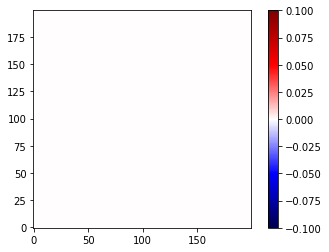

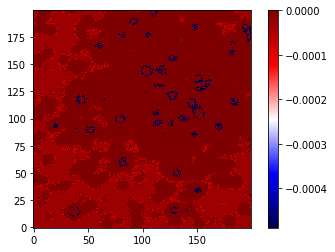

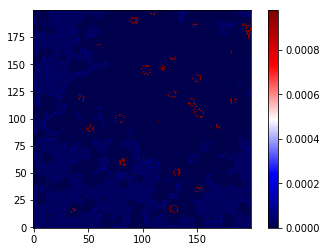

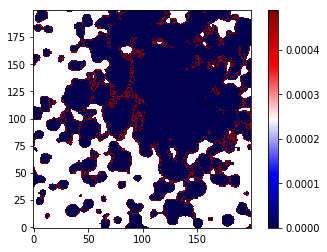

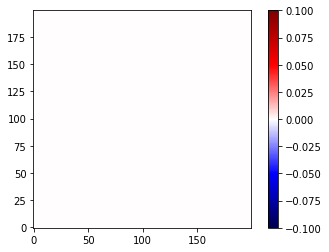

In [4]:
diff = _subset - images
bkg_med = np.median(diff, axis=(1, 2))
print("Subtracting background offset from DECam images")
subset = _subset - bkg_med[:, None, None]
diff = subset - images
for n, i in enumerate(diff):
    plt.imshow(i, cmap="seismic")
    plt.colorbar()
    plt.show()

# Add the mask into the weights

We want to be conservative in regards to the bad pixels, whereas the DECam pipeline seems to have small but non-zero weights for pixels that are masked in the data quality mask. So we also set those to zero

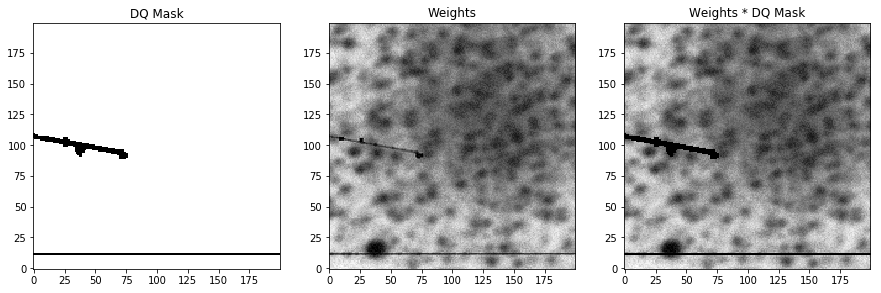

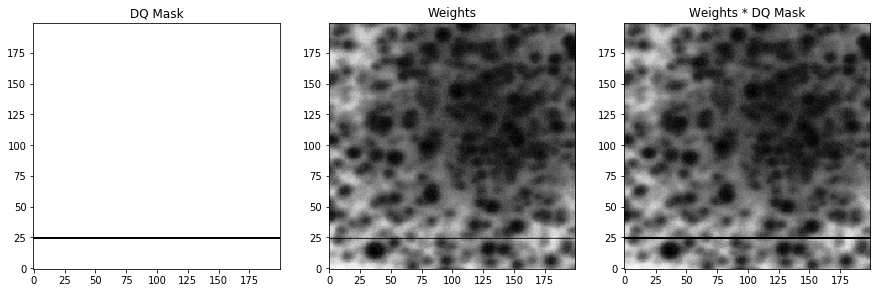

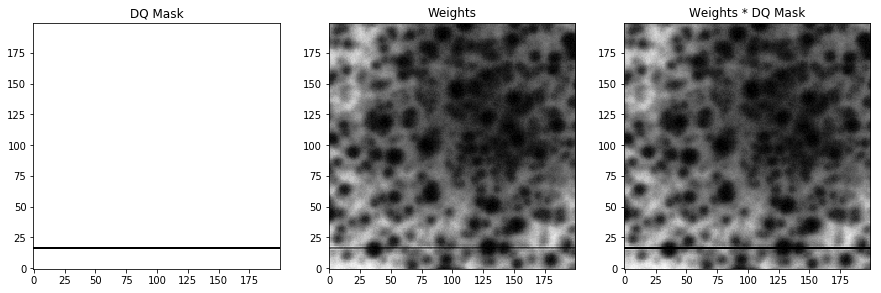

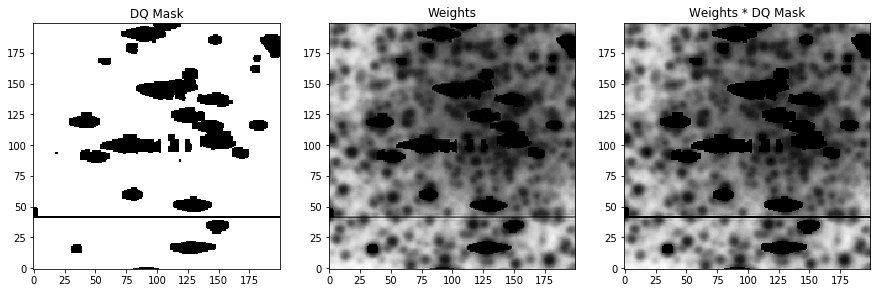

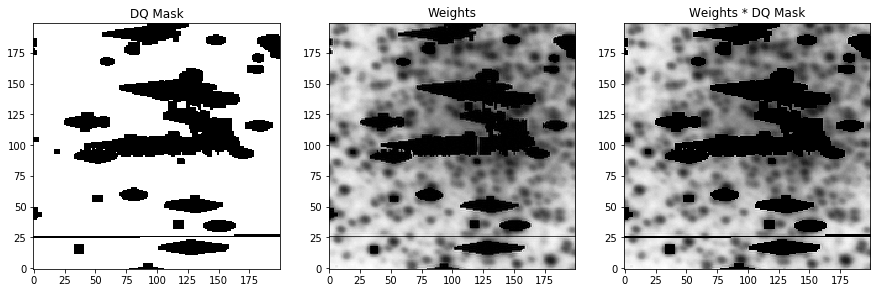

In [5]:
weights = _weights * mask
for m, _w, w in zip(mask, _weights, weights):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(m)
    ax[0].set_title("DQ Mask")
    ax[1].imshow(_w)
    ax[1].set_title("Weights")
    ax[2].imshow(w)
    ax[2].set_title("Weights * DQ Mask")
    plt.show()

# Detect sources in the image

We run SEP in each band to see which catalog performs best. Ideally we need to do better detection in each band, although after playing with it for a while this was the best I could do. Once we have done a better job detecting in each band we then want to create a merged catalog that has the detections across bands, to have a more complete catalog. So this is just a first pass at a work in progress.

For now I chose the i-band catalog, since it has the most sources of the three bands with well behaved PSFs and little saturation.

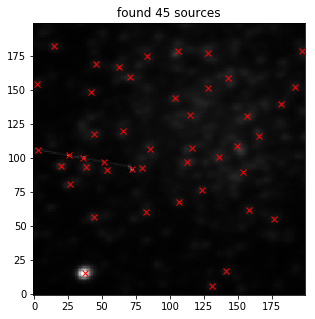

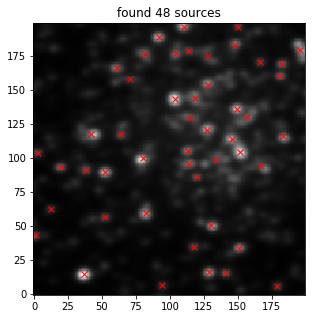

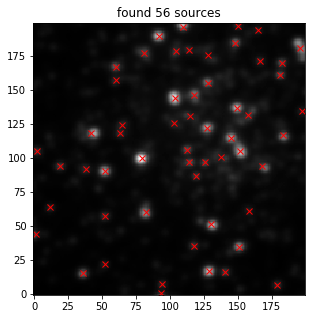

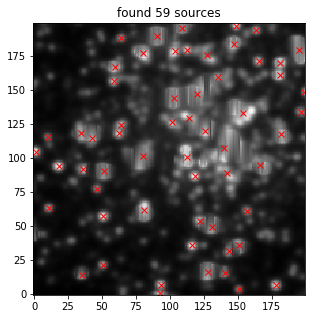

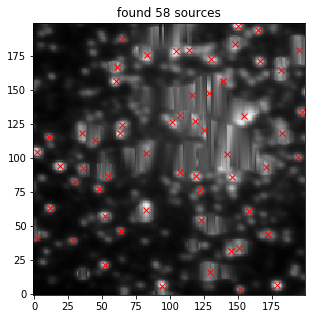

In [6]:
import sep

__weights = weights.copy()
__weights[__weights==0] = 1e-15
variance = 1/__weights

def makeCatalog(img, thresh=8):
    bkg = sep.Background(img)
    _img = img - bkg
    catalog = sep.extract(img, thresh=thresh, err=bkg.globalrms, minarea=1)
    return catalog

catalogs = []
for img, v in zip(images, variance):
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    
    catalog = makeCatalog(img)
    for src in catalog:
        plt.plot(src["x"], src["y"], "rx")
        plt.title("found {} sources".format(len(catalog)))
    
    plt.show()

# Display the data

We use an Asinh mapping to amplify the faint detections and see that we're missing a lot, as stated above

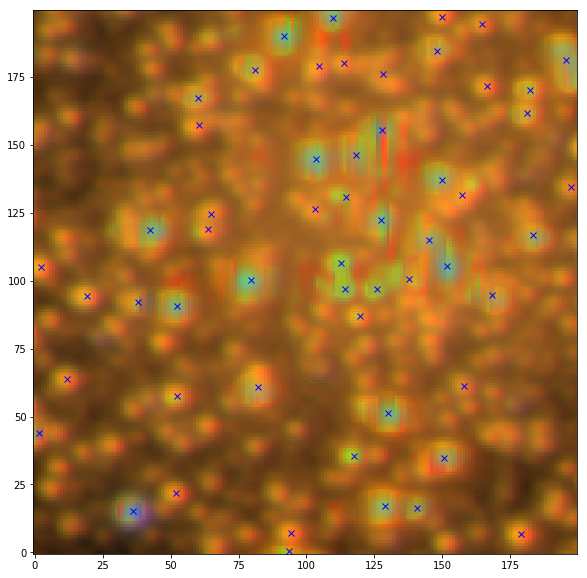

In [7]:
catalog = makeCatalog(images[2])

norm = display.AsinhMapping(minimum=np.min(subset), stretch=np.max(subset)*0.055, Q=10)
rgb = display.img_to_rgb(subset[1:], norm=norm)
plt.figure(figsize=(10, 10))
plt.imshow(rgb)

for src in catalog:
    plt.plot(src["x"], src["y"], "bx")

plt.show()

# Display the full PSFs

We first normalize the PSfs, a requirement for scarlet, to see the full color PSF in different bands

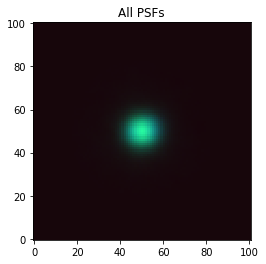

9.6027616e-05


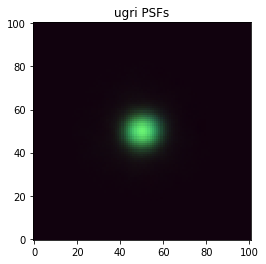

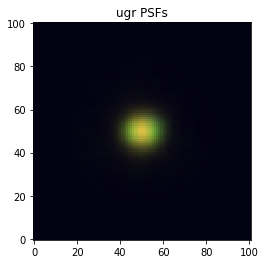

In [8]:
psfs = _psfs / np.sum(_psfs, axis=(1,2))[:, None, None]
norm = display.AsinhMapping(minimum=np.min(psfs), stretch=np.max(psfs)*0.055, Q=10)
rgb = display.img_to_rgb(psfs, norm=norm)
plt.figure(figsize=(4, 4)) 
plt.imshow(rgb)
plt.title("All PSFs")
plt.show()
print(np.min(psfs[-1]))

psfs = _psfs[:-1] / np.sum(_psfs[:-1], axis=(1,2))[:, None, None]
norm = display.AsinhMapping(minimum=np.min(psfs), stretch=np.max(psfs)*0.055, Q=10)
rgb = display.img_to_rgb(psfs, norm=norm)
plt.figure(figsize=(4, 4)) 
plt.imshow(rgb)
plt.title("ugri PSFs")
plt.show()

psfs = _psfs[:-2] / np.sum(_psfs[:-2], axis=(1,2))[:, None, None]
norm = display.AsinhMapping(minimum=np.min(psfs), stretch=np.max(psfs)*0.055, Q=10)
rgb = display.img_to_rgb(psfs, norm=norm)
plt.figure(figsize=(4, 4))
plt.imshow(rgb)
plt.title("ugr PSFs")
plt.show()

# Trim PSF and force to zero at edges

If the PSF doesn't go to zero at the edges we'll get bad artifacts in the convolved models. This is the red backgrounds that we saw in Michaels models. So we first trim the PSF, then subtract off the minimum to produce a better (but not necessarily well-behaved PSF). Really we have to do this better if we want to stand a chance at deblending this field

PSF centered at (50, 50)


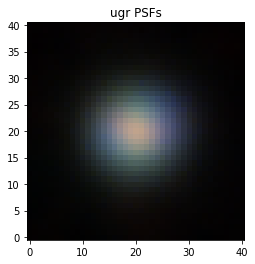

In [9]:
# The center should be (50, 50), the center of the PSF, we just double check here
py, px = np.unravel_index(np.argmax(_psfs[0]), (_psfs[0].shape))
print("PSF centered at ({}, {})".format(py, px))
pw = 20
psfs = _psfs[:, py-pw:py+pw+1, px-pw: px+pw+1]
psfs = psfs - np.min(psfs, axis=(1,2))[:, None, None]
psfs = psfs / np.sum(psfs, axis=(1,2))[:, None, None]

norm = display.AsinhMapping(minimum=np.min(psfs), stretch=np.max(psfs)*0.055, Q=10)
rgb = display.img_to_rgb(psfs, norm=norm)
plt.figure(figsize=(4, 4))
plt.imshow(rgb)
plt.title("ugr PSFs")
plt.show()

# Build the initial scarlet models

The PSFs in the `iz` bands do not seem to reproduce the images as given by Abi, so we ignore those and only model the 3 bands that we can cosntrain.

In [33]:
# Extract the coordinates for each source from the catalog
centers = np.array([c for c in zip(catalog["y"], catalog["x"])])

model_psf = scarlet.PSF(partial(scarlet.psf.gaussian, sigma=1/np.sqrt(2)), shape=(None, 11, 11))

_images = images[:3]
_psfs = psfs[:3]
_filters = "ugr"
_weights = weights[:3]

model_frame = scarlet.Frame(
            _images.shape,
            psfs=model_psf,
            channels=_filters)

observation = scarlet.Observation(
            _images,
            psfs=_psfs,
            weights=_weights,
            channels=_filters).match(model_frame)

sources = []
for center in centers:
        # This is just an internal script that I have to first attempt to model each
        # source with `max_components`, in this case an `ExtendedSource` but fallback
        # to a point source if modeling as an `ExtendedSource` fails
        src = se.initialization.initSource(
            model_frame, center, observation, max_components=1, thresh=1
        )
        if src is not None:
            sources.append(src)
blend = scarlet.Blend(sources, observation)

# Display a few models

Just to see how we are initializing, lets look at our initial models

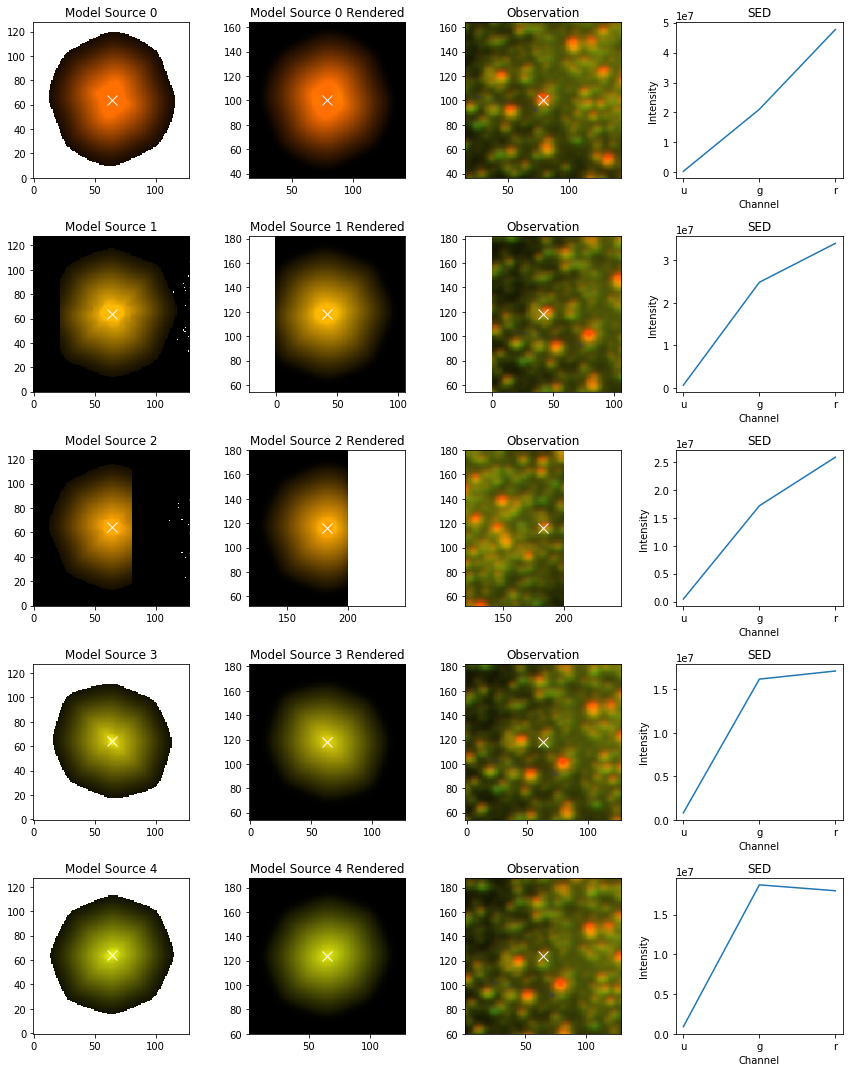

In [34]:
norm = display.AsinhMapping(minimum=np.min(images), stretch=np.max(images)*0.055, Q=10)

display.show_sources(blend.sources[20:25],
                         norm=norm,
                         observation=observation,
                         show_rendered=True,
                         show_observed=True)
plt.show()

# Fit the model

So the initial models are very bad, yet scarlet does a reasonable job (considering the number of undetected sources) starting with this bad model. We do notice color dipoles in the residuals, which means that either the PSFs are mis-aligned or the images are.

CPU times: user 5min 29s, sys: 9.95 s, total: 5min 39s
Wall time: 1min 33s


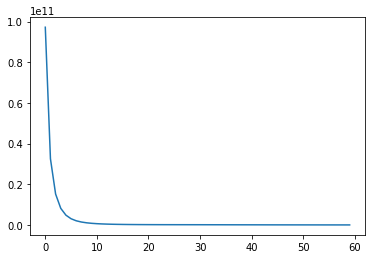

174242495680.38953


In [35]:
%time blend.fit(1000, e_rel=1e-4)
plt.plot(np.array(blend.loss))
plt.show()
print(np.sum(blend.loss))

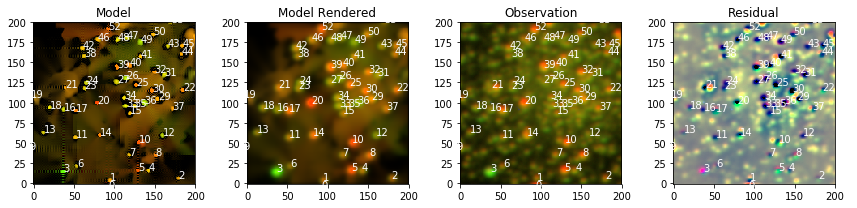

In [36]:
norm = display.AsinhMapping(minimum=np.min(images), stretch=np.max(images)*0.055, Q=10)
display.show_scene(sources, observation, show_observed=True, show_rendered=True, show_residual=True, norm=norm)
plt.show()

# Point sources

scarlet is actually able to do a decent job of fitting the model in the `ugr` bands given all of the undetected sources. But the model that we used is designed to model sources as extended objects, namely galaxies or other morphologically complex objects that can contain flux far from the center. This is not the case in a crowded field, and we likely don't want to model objects in areas this dense as extended sources until we have exhausted the possibilities of modeling them as point sources. So now we try to model everything as a point source.

In [28]:
sources = [scarlet.PointSource(model_frame, center, observation) for center in centers]
blend = scarlet.Blend(sources, observation)

CPU times: user 29.6 s, sys: 486 ms, total: 30.1 s
Wall time: 14.1 s


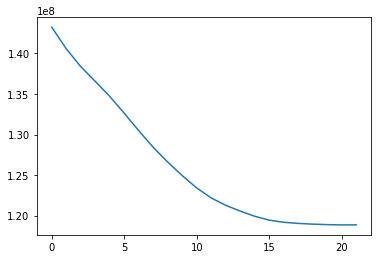

2777102186.9566207


In [29]:
%time blend.fit(1000, e_rel=1e-4)
plt.plot(np.array(blend.loss))
plt.show()
print(np.sum(blend.loss))

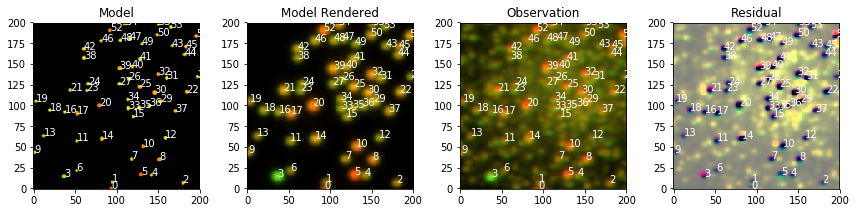

In [30]:
norm = display.AsinhMapping(minimum=np.min(images), stretch=np.max(images)*0.055, Q=10)
display.show_scene(sources, observation, show_observed=True, show_rendered=True, show_residual=True, norm=norm)
plt.show()

# Attempt to deblend all bands

As mentioned above, there is something very wrong with the `i` and `z` band data. This is likely more than just undetected sources, as the `ugr` deblending above also had a large number of undetected sources yet was able to do a "decent" but not great job. It could be that there are so many undetected red stars that scarlet really does catastrophically fail, but at this point I think it's more likely an issue with either the PSF or the alignment of the images that is causing this failure.

In [37]:
model_frame = scarlet.Frame(
            images.shape,
            psfs=model_psf,
            channels=filters)

observation = scarlet.Observation(
            images,
            psfs=psfs,
            weights=weights,
            channels=filters).match(model_frame)

sources = []
for center in centers:
        # This is just an internal script that I have to first attempt to model each
        # source with `max_components`, in this case an `ExtendedSource` but fallback
        # to a point source if modeling as an `ExtendedSource` fails
        src = se.initialization.initSource(
            model_frame, center, observation, max_components=1, thresh=1
        )
        if src is not None:
            sources.append(src)
blend = scarlet.Blend(sources, observation)

CPU times: user 5min 51s, sys: 9.99 s, total: 6min 1s
Wall time: 1min 37s


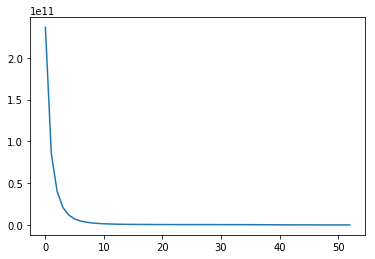

439857359516.5578


In [39]:
%time blend.fit(300, e_rel=1e-4)
plt.plot(np.array(blend.loss))
plt.show()
print(np.sum(blend.loss))

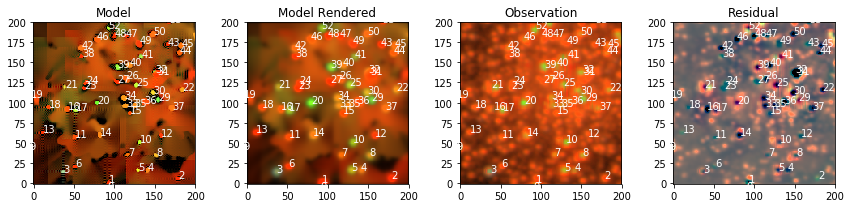

In [40]:
norm = display.AsinhMapping(minimum=np.min(images), stretch=np.max(images)*0.055, Q=10)
display.show_scene(sources, observation, show_observed=True, show_rendered=True, show_residual=True, norm=norm)
plt.show()

Well, it does something... While the results aren't terrible, it's obvious that we need to detect a lot more sources in order to seed the initial model.

In [41]:
sources = [scarlet.PointSource(model_frame, center, observation) for center in centers]
blend = scarlet.Blend(sources, observation)

CPU times: user 7min 32s, sys: 8.82 s, total: 7min 41s
Wall time: 3min 35s


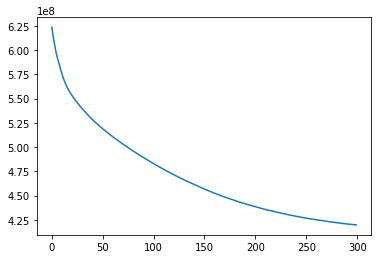

141269483058.10663


In [42]:
%time blend.fit(300, e_rel=1e-4)
plt.plot(np.array(blend.loss))
plt.show()
print(np.sum(blend.loss))

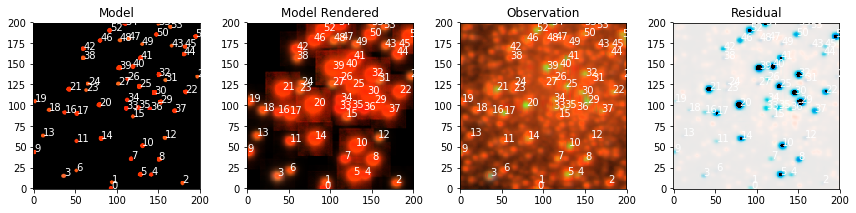

In [43]:
norm = display.AsinhMapping(minimum=np.min(images), stretch=np.max(images)*0.055, Q=10)
display.show_scene(sources, observation, show_observed=True, show_rendered=True, show_residual=True, norm=norm)
plt.show()

In this case the point source model was worse! This is probably because it is trying to model the background with the same PSf, causing it to give way too much flux to the redder bands. Below we see the model for just the `ugr` bands, which looks more reasonable.

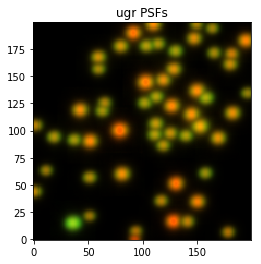

In [47]:
model = observation.render(blend.get_model())[:3]
rgb = display.img_to_rgb(model, norm=norm)
plt.figure(figsize=(4, 4))
plt.imshow(rgb)
plt.title("ugr PSFs")
plt.show()